# Proof of Concept

Figures to recreate:
* Coverage vs. Atypicality Quantile - for any CP algorithm, data generation, and atypicality score setting 
* Efficiency vs. Atypicality (cut?)
* Proof of Concept (3x3) - for true atypicality
* Proof of Concept (3x3) - for predicted atypicality
* Distribution of True value in the interval

In [ ]:
import sys
sys.path.append("../src")

from atypicality import compute_atypicality_scores
from data_generation_settings import generate_and_split_gaussian_data, generate_and_split_lognormal_data, generate_and_split_gmm_data
from fit_cp_models import fit_rf_cp_model, predict_cp_intervals
from compute_bounds import evaluate_lambda_adjusted_interval_coverage
from plotting import plot_coverage_across_atypicality_quantile

# Calculating Coverage vs. Atypicality Quantile for any experimental setting

In [ ]:
atypicality_settings = [
    ('logjointmvn_score', 0),
    ('logjointmvn_score', 0.5),
    ('logjointmvn_score', 1),
    ('gmm_score', 1)
]

# Run calibration across all atypicality types
coverage_by_quantile_lambda = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=generate_and_split_lognormal_data, 
                                        fit_cp_model=fit_rf_cp_model, 
                                        n_samples=500,
                                        n_splits=3, 
                                        test_atypicality=True,
                                        num_quantiles=5)

# Peek at output: coverage across atypicality score, quantile, split, and lambda
coverage_by_quantile_lambda.head(5)

/Users/audreyxychang/Documents/GitHub/extending-atypicality/notebooks/../src/data_generation_settings.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = np.random.multivariate_normal(mean, cov, size=n_samples)
0it [00:00, ?it/s]


ValueError: Invalid score type: logjointmvn_score

../plots/coverage_vs_logjointmvn_lam_0p0_0p5_1p0.png


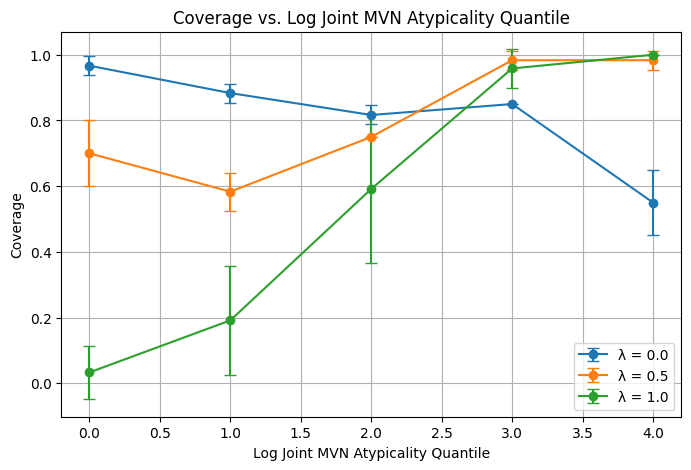

In [ ]:
# Plot result for a specific score
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)


In [38]:
(coverage_by_quantile_lambda.groupby(['lambda', 'quantile'])['coverage']
        .agg(['mean', 'std'])
        .reset_index())

,lambda,quantile,mean,std
0,0.0,0,0.966667,0.028868
1,0.0,1,0.883333,0.028868
2,0.0,2,0.816667,0.028868
3,0.0,3,0.850000,0.000000
4,0.0,4,0.550000,0.100000
5,0.5,0,0.700000,0.100000
6,0.5,1,0.583333,0.057735
7,0.5,2,0.750000,0.000000
8,0.5,3,0.983333,0.028868
9,0.5,4,0.983333,0.028868
